<a href="https://colab.research.google.com/github/bigvisionai/upgrad_alumni_workshop_day2/blob/master/face_recognition/OpenCV_DNN_Face_Detection_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Face Detection and Face Recognition using OpenCV DNN

**_Face Detection is a computer vision technique which enables a computer to find faces in an image whereas Face Recognition is the technique that can predict the identity of a person from an image._**

### Face Detection
We need to detect a bounding box around the face (just like Object Detection). There are hundreds of models that perform Face Detection. We will be using [YuNet Face Detection Model](https://github.com/opencv/opencv_zoo/tree/master/models/face_detection_yunet) for this discussion which was added recently to the OpenCV Model Zoo. It is only ~300KB in size! The main reason of using this face detector is that this face detector also returns a 5 point facial landmarks along with the bounding box of faces. This will be useful in face alignment which is an essential step in Face Recognition.

### Face Recognition
We need to learn a high-dimensional feature space which is capable of distinguishing between faces of different persons. Once we have a trained model, we can use it to generate unique features (also called embeddings) for each face. Finally, we can compare features of new faces with that of known faces to identify the person.

In case we want to add a new person to the database of known faces, we simply generate the features and add it to the database. This process is called **Enrolment**.

There are many models that perform face Recognition like FaceNet, Arcface, etc. We will use  [SFace: Sigmoid-Constrained Hypersphere Loss for Robust Face Recognition](https://github.com/opencv/opencv_zoo/tree/master/models/face_recognition_sface) in this notebook.

In [1]:
if 'google.colab' in str(get_ipython()):
    print("Downloading Code to Colab Environment")
    !wget https://www.dropbox.com/sh/d1f0zadon1ffpue/AADTRTxWKD501zizH6vaaTORa?dl=1 -O code.zip -q --show-progress
    !unzip -qq code.zip
    !pip install --upgrade opencv-contrib-python
else:
    pass

code.zip            100%[===================>]  38.57M  47.9MB/s    in 0.8s    
mapname:  conversion of  failed
     |████████████████████████████████| 66.7 MB 32 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Global Constants

In [2]:
# Colors.
blue = (255, 0, 0)
green = (0, 255, 0)
red = (0, 0, 255)
yellow = (0, 255, 255)
cyan = (255, 0, 255)

## 1 Load Images

Let us first load a few images and display them

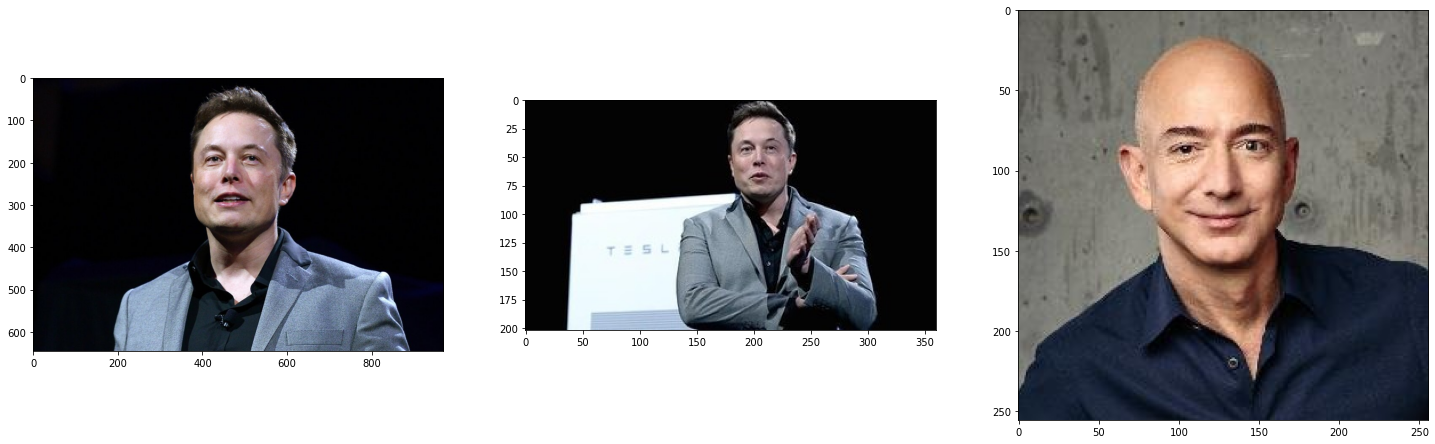

In [3]:
# Load images for comparison.
img1 = cv2.imread("musk1.jpg")
img2 = cv2.imread("musk2.jpg")
img3 = cv2.imread("jeff1.jpg")

plt.figure(figsize=(25,10))
plt.subplot(131); plt.imshow(img1[...,::-1]);
plt.subplot(132); plt.imshow(img2[...,::-1]);
plt.subplot(133); plt.imshow(img3[...,::-1]);

## 2 Face Detection
We will create a face detector object and then call the detect method for finding the faces. This face detector also returns a 5 point facial landmarks along with the bounding box of faces.

### 2.1 Create Face Detector Object
```
retval = cv2.FaceDetectorYN.create(model, config, input_size, score_threshold, nms_threshold, top_k, backend_id, target_id)
```
Where,

- `retval` is the flag for succeful operation

The detector has **three required parameters**.
 - `model` : Path to the model file
 - `config` : Not required for ONNX model. Added for compatibility.
 - `input_size` : The input size of the image accpted by the network. 

[Link to Documentation](https://docs.opencv.org/4.x/df/d20/classcv_1_1FaceDetectorYN.html#a42293cf2d64f8b69a707ab70d11925b3)


In [4]:
# Model paths.
face_detection_model = 'face_detection_yunet_2021dec.onnx'
face_recognition_model = 'face_recognition_sface_2021dec.onnx'

# Detector.
detector = cv2.FaceDetectorYN.create(face_detection_model, "", (320, 320))

### 2.2 Detect faces and corresponding 5 landmark points
```
retval, faces = cv2.FaceDetectorYN.detect(image)
```
Where,
- `retval` is the flag for succeful operation
- `faces` is an array containing the bounding box location of each detected face.

Each face array contains 15 elements:
- The first 4 elements correspond to the (x,y,w,h)
- The next 10 elements are the (x,y) locations of the 5 landmarks
- The last element is the confidence score

[Link to Documentation](https://docs.opencv.org/4.x/df/d20/classcv_1_1FaceDetectorYN.html#ac05bd075ca3e6edc0e328927aae6f45b)

In [6]:
# Image size.
img_height, img_width = img1.shape[:2]
# Set detector input size.
detector.setInputSize((img_width, img_height))
# Perform detection.
retval, faces = detector.detect(img1)

print(faces)

[[369.89722  98.30162 225.39175 257.74884 425.77182 190.2844  524.97296
  194.86313 463.4129  246.4247  424.43988 282.80283 514.17896 286.89056
    1.     ]]


### 2.3 Display Detections
This functions renders bounding box and five landmarks on the detected face.

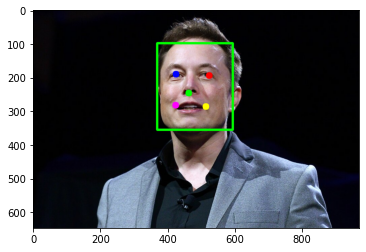

In [7]:
def display_detections(img, faces, radius=10, thickness=5):
    im = img.copy()
    if faces is not None:
        for idx, face in enumerate(faces):           
            coords = face[:-1].astype(np.int32)
            tlc = (coords[0], coords[1])
            brc = (coords[0]+coords[2], coords[1]+coords[3])
            cv2.rectangle(im, tlc, brc, green, thickness)
            cv2.circle(im, (coords[4], coords[5]), radius, blue, -1)
            cv2.circle(im, (coords[6], coords[7]), radius, red, -1)
            cv2.circle(im, (coords[8], coords[9]), radius, green, -1)
            cv2.circle(im, (coords[10], coords[11]), radius, cyan, -1)
            cv2.circle(im, (coords[12], coords[13]), radius, yellow, -1)
    plt.imshow(im[:,:,::-1])

display_detections(img1, faces)

## 3 Face Recognition

The Face Recognizer provides the following methods:
- `alignCrop` for preprocessing the face by aligning the face and then cropping it to a standard size
- `feature` for computing the feature embedding
- `match` for matching 2 feature embeddings using a distance metric ( Cosine Similarity and L2 are supported )

### 3.1 Create a face recognizer object
```
retval = cv2.FaceRecognizerSF.create(model)
```

It has **two required parameters**, `model` and the `config` file. However, ONNX model does not need config file. The `backend_id` and `target_id` are **optional parameters** with default value 0, 0 respectively.

In [8]:
recognizer = cv2.FaceRecognizerSF.create(face_recognition_model, "")

### 3.2 Align and Crop Face

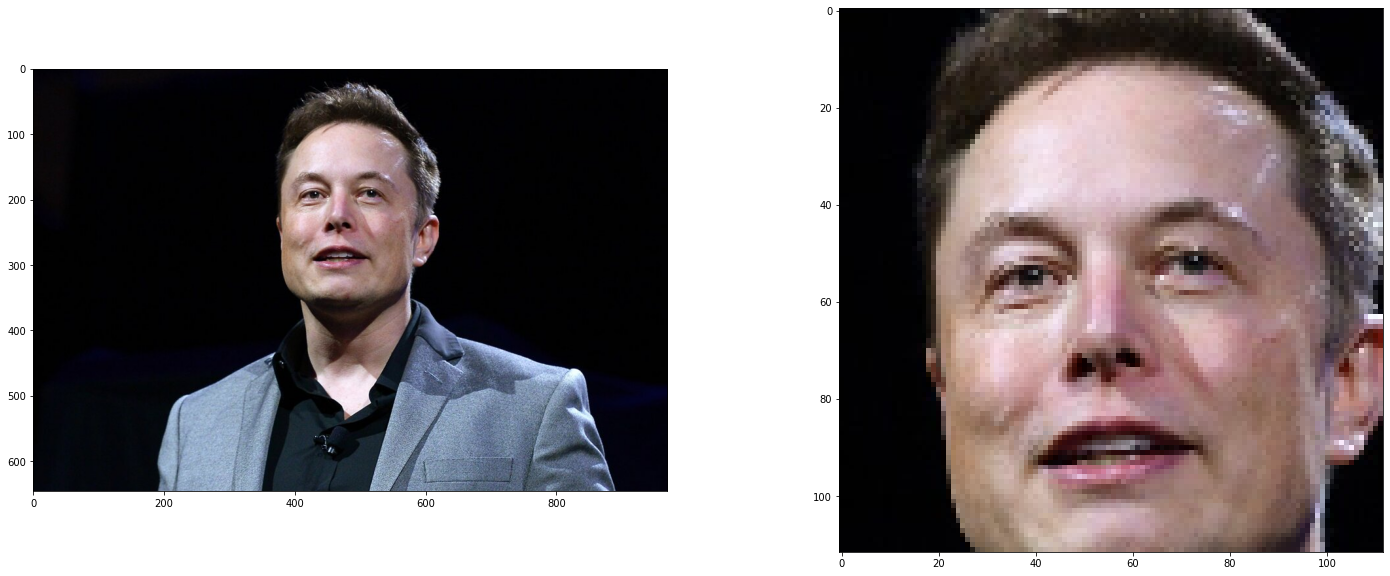

In [9]:
aligned_face = recognizer.alignCrop(img1, faces[0])

plt.figure(figsize=(25,10))
plt.subplot(121); plt.imshow(img1[...,::-1]);
plt.subplot(122); plt.imshow(aligned_face[...,::-1]);

### 3.3 Find Face Feature / Embeddings

In [10]:
face_embedding = recognizer.feature(aligned_face)
print(face_embedding)
print("Face Embedding dimenion: {}".format(len(face_embedding[0])))

[[-6.7145306e-01 -1.4585419e+00  7.9973891e-02 -1.4818271e+00
  -1.7937756e-01 -4.6636128e-01 -1.4775099e+00 -9.4767076e-01
  -1.2199535e+00  4.3441379e-01 -1.0102154e+00 -1.7284992e+00
  -4.9501311e-02  2.0273051e+00 -3.9930692e-01 -2.9448426e-01
   5.3123611e-01 -2.2982349e-01 -2.3545742e+00  2.4371805e+00
   8.6908370e-01 -2.3061574e-01  1.0697496e+00 -7.8080446e-02
   1.3357532e+00 -9.2680538e-01 -1.9298215e+00  1.7303381e+00
  -2.7259937e-01  3.1043577e-01  1.0044311e+00 -1.3356346e+00
   2.2371285e-01  6.7341143e-01 -2.4344021e-01 -1.2377477e+00
  -5.0503224e-01  1.3332052e+00  1.5197543e+00 -7.9668421e-01
   6.9372499e-01  3.7181500e-01  3.1636569e-01  6.3239104e-01
  -7.8306311e-01 -7.5991374e-01 -3.2515210e-01  2.0527647e+00
   5.3615749e-01  1.4747514e+00 -1.0017415e-01  1.2084584e+00
   3.7968239e-01 -1.5126818e+00  1.0544103e+00 -8.6680520e-01
   3.3234453e-01 -1.3724147e+00 -1.1181327e+00 -2.2499921e+00
  -8.2292885e-01  1.1214474e+00 -2.6721878e+00 -8.4007996e-01
   8.745

### 3.4 Verify Face

Let us find the embeddings for another image and then compare the two embeddings.

In [12]:
# Image size.
img_height, img_width = img2.shape[:2]
# Set detector input size.
detector.setInputSize((img_width, img_height))
# Perform detection.
retval, faces2 = detector.detect(img2)
# Align Face.
aligned_face2 = recognizer.alignCrop(img2, faces2[0])
# Find Embedding.
face_embedding2 = recognizer.feature(aligned_face2)

cosine_score = recognizer.match(face_embedding, face_embedding2, cv2.FaceRecognizerSF_FR_COSINE)
l2_score = recognizer.match(face_embedding, face_embedding2, cv2.FaceRecognizerSF_FR_NORM_L2)

print("Cosine Score: {:.2f}\nL2 Score: {:.2f}".format(cosine_score, l2_score))

Cosine Score: 0.84
L2 Score: 0.56


### 3.5 Define Thresholds
Two faces have the same identity if
- the cosine distance is greater than or equal to 0.363, or 
- the norm L2 distance is less than or equal to 1.128

In [ ]:
# Similarity thresholds.
cosine_similarity_thresh = 0.363
l2_similarity_thresh = 1.128

Looking at the scores and thresholds, we can say that the two faces are of the same person, which is indeed the case.

### 4 Creating a utility function for Face Verification

Let us put together all the code described above in a single function and create a utility function to verify faces.

In [13]:
def getEmbedding(img):
    # Image size.
    img_height, img_width = img.shape[:2]
    # Set detector input size.
    detector.setInputSize((img_width, img_height))
    # Perform detection.
    retval, faces = detector.detect(img)
    # Align and crop faces.
    aligned_face = recognizer.alignCrop(img, faces[0])
    # Extract features.
    face_embedding = recognizer.feature(aligned_face)
    
    return face_embedding

In [15]:
def verify_faces(img1, img2):
    # Get face embeddings.
    face_embedding1 = getEmbedding(img1)
    face_embedding2 = getEmbedding(img2)

    cosine_score = recognizer.match(face_embedding1, face_embedding2, cv2.FaceRecognizerSF_FR_COSINE)   
    l2_score = recognizer.match(face_embedding1, face_embedding2, cv2.FaceRecognizerSF_FR_NORM_L2)

    if cosine_score > cosine_similarity_thresh:
        print('Cosine Similarity Method : Same Person')
    else:
        print('Cosine Similarity Method : Different Person')

    if l2_score < l2_similarity_thresh:
        print('L2 Similarity Method : Same Person')
    else:
        print('L2 Similarity Method : Different Person')
    


## 5 Results

### 5.1 Test1 : Elon Musk and Elon Musk

Cosine Similarity Method : Same Person
L2 Similarity Method : Same Person


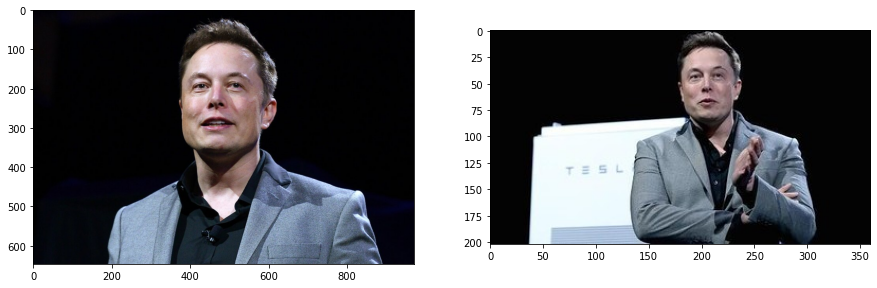

In [17]:
img1 = cv2.imread('musk1.jpg')
img2 = cv2.imread('musk2.jpg')
plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(img1[...,::-1]);
plt.subplot(122); plt.imshow(img2[...,::-1]);
verify_faces(img1,img2)

### 5.2 Test2 : Elon Musk and Jeff Bezos

Cosine Similarity Method : Different Person
L2 Similarity Method : Different Person


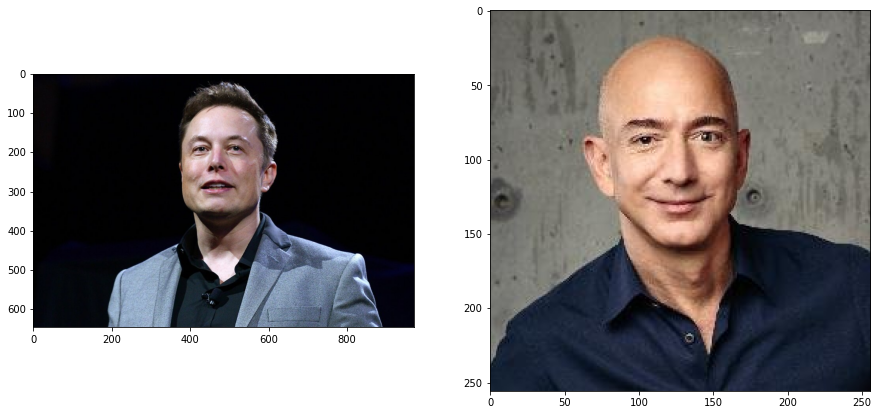

In [18]:
img1 = cv2.imread('musk1.jpg')
img2 = cv2.imread('jeff1.jpg')
plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(img1[...,::-1]);
plt.subplot(122); plt.imshow(img2[...,::-1]);
verify_faces(img1,img2)

### 5.2 Test3 : Elon Musk and Satya Mallick

Cosine Similarity Method : Different Person
L2 Similarity Method : Different Person


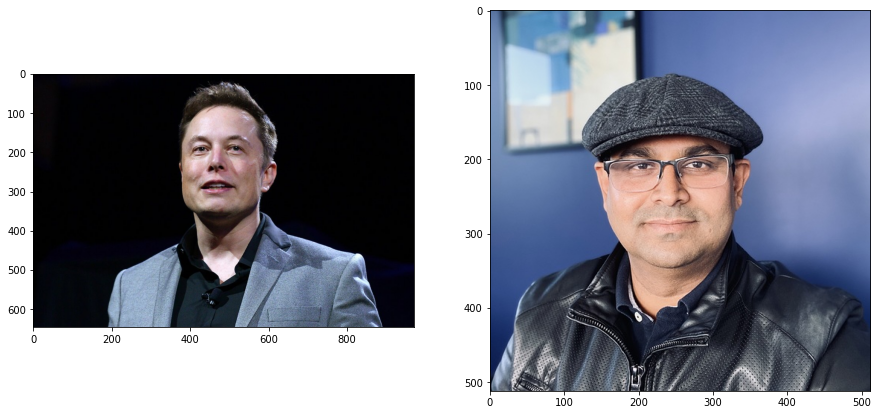

In [19]:
img1 = cv2.imread('musk1.jpg')
img2 = cv2.imread('satya.jpg')
plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(img1[...,::-1]);
plt.subplot(122); plt.imshow(img2[...,::-1]);
verify_faces(img1,img2)